Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Set parameters 
data_dir = r'../data/'
syn_thresh = 5

In [4]:
# Load connectivity 
df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [5]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [6]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [7]:
# Get IDs
all_nodes = pd.unique(df_connectivity[['pre_root_id', 'post_root_id']].values.ravel('K')) 

In [8]:
# Build network graph
net = nx.DiGraph() 

# Add nodes
net.add_nodes_from(all_nodes)

# Add edges
for index, row in tqdm(df_connectivity.iterrows(), total=np.size(df_connectivity,axis=0)): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))  

100%|█████████████████████████████████████████████████████████████████████| 3732460/3732460 [01:47<00:00, 34854.71it/s]


In [24]:
def compute_shortest_path(net, source_nodes, target_nodes):
    
    # For every source node, find shortest path to any target node
    hops = []
    for source_node in source_nodes:
        hops_temp = []
        for target_node in target_nodes: 
            if source_node in net.nodes() and target_node in net.nodes():
                if nx.has_path(net, source_node, target_node):
                    shortest_path = nx.shortest_path(net, source=source_node, target=target_node)
                    hops_temp.append(len(shortest_path)-1)
        if len(hops_temp)>0:
            hops.append(np.min(hops_temp))

    return hops

In [26]:
# Compute shortest paths
source_classes = ['mechanosensory', 'visual', 'olfactory', 'thermosensory', 'gustatory','hygrosensory']

hops_RRN, hops_BPN = [], []
for source_index, source_class in enumerate(source_classes):
    source_nodes = df_class.root_id[(df_class['class']==source_class)].unique().tolist()

    target_nodes = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name.str.contains('RRN')].tolist()
    hops = compute_shortest_path(net, source_nodes, target_nodes)
    hops_RRN.append(np.mean(hops))

    target_nodes = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
    hops = compute_shortest_path(net, source_nodes, target_nodes)
    hops_BPN.append(np.mean(hops))

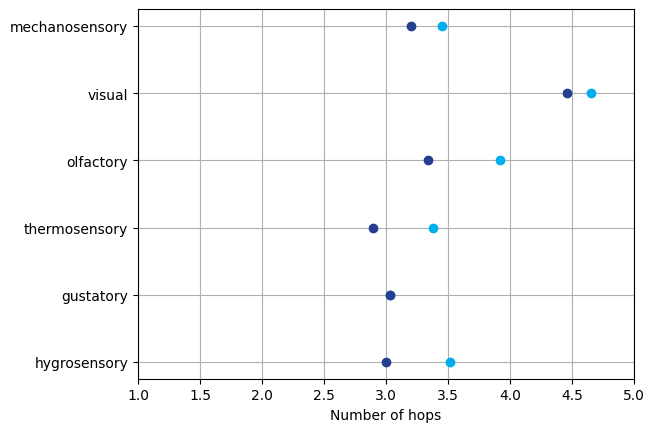

In [29]:
# Plot hops from source neurons
fig, ax = plt.subplots()
plt.plot(hops_RRN, range(len(source_classes)), 'o', color=[0/255,173/255,238/255,1])
plt.plot(hops_BPN, range(len(source_classes)), 'o', color=[36/255,62/255,144/255,1])
ax.set_yticks(range(len(source_classes)))
ax.set_yticklabels(source_classes)
plt.xlim([1,5])
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('Number of hops')
plt.show()